In [1]:
import importlib
import xarray as xr
import numpy as np
import sys

import matplotlib.pyplot as plt

from CASutils import mapplot_utils as maps
from CASutils import readdata_utils as read
from CASutils import calendar_utils as cal
from CASutils import colorbar_utils as cbars
from CASutils import shapefile_utils as shp
from CASutils import colormap_utils as mycolors

from math import nan

importlib.reload(maps)
importlib.reload(read)
importlib.reload(cbars)

import cartopy.crs as ccrs

In [2]:
plotpath="/project/cas/islas/python_plots/snowpaper/FIGURES/"

In [3]:
era5ps = xr.open_dataset("/project/cas/islas/python_savs/snowpaper/DATA_SORT/era5_ps/PS_ERA5_1979_2014_DJF.nc")
era5ps = era5ps.ps
era5ps = era5ps/100.
era5ps = era5ps.drop('season')

In [4]:
datera5 = xr.open_dataset("/project/cas/islas/python_savs/snowpaper/DATA_SORT/flux_trefht_gradients/"+
                          "gradients_ERA5.nc")
datclm5 = xr.open_dataset("/project/cas/islas/python_savs/snowpaper/DATA_SORT/flux_trefht_gradients/"+
                          "gradients_Isla_CAM6_CLM5_002.nc")
datsnowd = xr.open_dataset("/project/cas/islas/python_savs/snowpaper/DATA_SORT/flux_trefht_gradients/"+
                           "gradients_CAM6_CLM5_snowdensity_002.nc")
datfluxnet = xr.open_dataset("/project/cas/islas/python_savs/snowpaper/DATA_SORT/flux_trefht_gradients/"+
                            "fluxnet_gradients.nc")
datera5_comp = xr.open_dataset("/project/cas/islas/python_savs/snowpaper/DATA_SORT/trefhtptile_composites/"+
                               "pos_neg_extremes/ERA5_minmax_trefhtptilecomposite.nc")

In [5]:
### greenland mask
shpfile="/project/cas/islas/shapefiles/greenland/gadm36_GRL_0.shp"
maskgreenland = shp.maskgen(shpfile, era5ps, ['Greenland'])

landfrac = xr.open_dataset('/project/cas/islas/cesmle/fx/landfraclens.nc')
landfrac = landfrac.LANDFRAC.isel(time=0)

path="/project/cas02/islas/CLM5_CLM4/raw/Isla_CAM6_CLM5_002/mon/lnd/"
fsno_clm5 = read.read_sfc_cesm(path+"FSNO_f.e21.FHIST.f09_f09.cesm2_cam6_clm5.002.1979-01_2014-12.nc","1979-01","2014-12")
fsno_clm5_djf = cal.season_mean(fsno_clm5,"FSNO",season="DJF")

path="/project/cas02/islas/CLM5_CLM4/raw/CAM6_CLM5_snowdensity_002/mon/lnd/"
fsno_snowd = read.read_sfc_cesm(path+"FSNO_f.e21.FHIST_BGC.f09_f09.cesm2_cam6_clm5_snowdensity.002.1979-01_2014-12.nc","1979-01","2014-12")
fsno_snowd_djf = cal.season_mean(fsno_snowd,"FSNO", season="DJF")

maskclm5 = np.zeros([landfrac.lat.size, landfrac.lon.size])
maskclm5[ (fsno_clm5_djf > 0.5)] = 1
maskclm5 = xr.DataArray(maskclm5, coords=[landfrac.lat, landfrac.lon], dims=['lat','lon'], name='maskclm5')

maskclm5inverse = np.where( (maskclm5 == 1) |  (landfrac < 0.5), nan, 1)

masking Greenland


/project/cas/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/project/cas/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


In [6]:
### only include the fluxnet stations if fsno_clm5_djf > 0.5
fnetmask = xr.DataArray(np.ones([datfluxnet.station.size]), coords=[datfluxnet.station], dims=['station'], name='fnetmask')
for istation in np.arange(0,datfluxnet.station.size,1):
    lonfnet = datfluxnet.lon.isel(station=istation) ; latfnet = datfluxnet.lat.isel(station=istation)
    maskval = maskclm5.sel(lon=lonfnet, lat=latfnet, method='nearest')
    if (maskval.values == 0):
        fnetmask[istation] = nan

In [7]:
datera5 = datera5*np.array(landfrac)*maskclm5
datclm5 = datclm5*np.array(landfrac)*maskclm5
datsnowd = datsnowd*np.array(landfrac)*maskclm5
datfluxnet = datfluxnet*fnetmask

/project/cas/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'level'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


<Figure size 1152x1152 with 0 Axes>

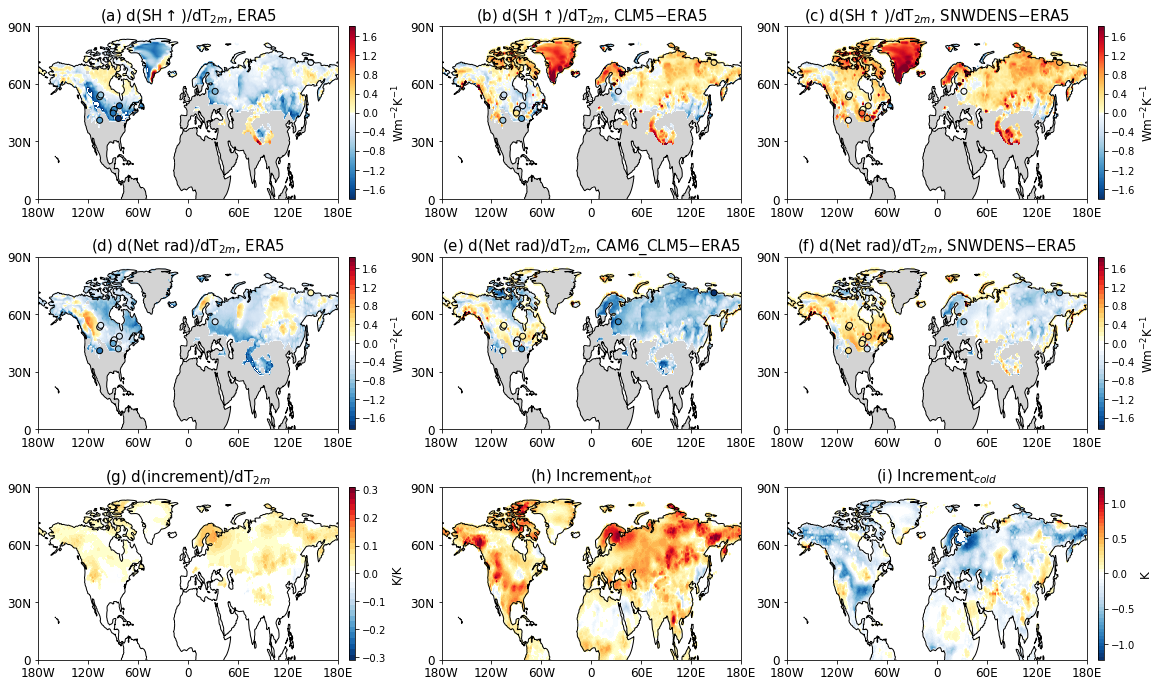

In [8]:
fig = plt.figure(figsize=(16,16))

#--------------Sensible heat flux
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, -1.*datera5.bshflx, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(a) d(SH$\\uparrow$)/dT$_{2m}$, ERA5',0.05, 0.31,0.8,0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_fnet, datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')
ax = cbars.plotcolorbar(fig, 0.02, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.32,0.325,0.8,0.95,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)



ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datclm5.bshflx - (-1.*datera5.bshflx), datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(b) d(SH$\\uparrow$)/dT$_{2m}$, CLM5$-$ERA5',0.4, 0.66, 0.8, 0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_clm5 - datfluxnet.b_shflx_fnet, 
                                                             datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datsnowd.bshflx - (-1.*datera5.bshflx), datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(c) d(SH$\\uparrow$)/dT$_{2m}$, SNWDENS$-$ERA5',0.7, 0.96, 0.8, 0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_snowd - datfluxnet.b_shflx_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = cbars.plotcolorbar(fig, 0.02, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.97,0.975,0.8,0.95,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)
#-------------------end sensible heat flux

#-------------------Net radiation
ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(d) d(Net rad)/dT$_{2m}$, ERA5',
                                                0.05, 0.31,0.6,0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_fnet, datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = cbars.plotcolorbar(fig, 0.1, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.32,0.325,0.6,0.75,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)



ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datclm5.bnetrad - datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,
                                            '(e) d(Net rad)/dT$_{2m}$, CAM6_CLM5$-$ERA5',
                                                0.4, 0.66, 0.6, 0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_clm5 - datfluxnet.b_netrad_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')


ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datsnowd.bnetrad - datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,
                                            '(f) d(Net rad)/dT$_{2m}$, SNWDENS$-$ERA5',
                                                0.7, 0.96, 0.6, 0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_snowd - datfluxnet.b_netrad_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = cbars.plotcolorbar(fig, 0.1, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.97,0.975,0.6,0.75,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)
#----------------------------------end net radiation

#------------------------analysis increments
ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5.bincrement, datera5.lon, datera5.lat,
                                               0.02,-0.3,0.3,'(g) d(increment)/dT$_{2m}$',
                                               0.05,0.31,0.4,0.55)
ax = cbars.plotcolorbar(fig, 0.02, -0.3, 0.3, 'K/K', 0.32,0.325,0.4,0.55,
                       ticks=[-0.3,-0.2,-0.1,0,0.1,0.2,0.3], orient='vertical', fsize=10)

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5_comp.maxincrement, datera5_comp.lon, datera5_comp.lat,
                                               0.05,-1.2,1.2,'(h) Increment$_{hot}$ ',0.4,0.66,0.4,0.55)#

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5_comp.minincrement, datera5_comp.lon, datera5_comp.lat,
                                               0.05,-1.2,1.2,'(i) Increment$_{cold}$',0.7,0.96,0.4,0.55)

ax = cbars.plotcolorbar(fig, 0.05, -1.2, 1.2, 'K',0.97,0.975, 0.4,0.55,
                       ticks=[-1,-0.5,0,0.5,1], orient='vertical', fsize=10)
#--------------------------end analysis increments

fig.savefig(plotpath+'fig12.png', bbox_inches='tight', facecolor='white')


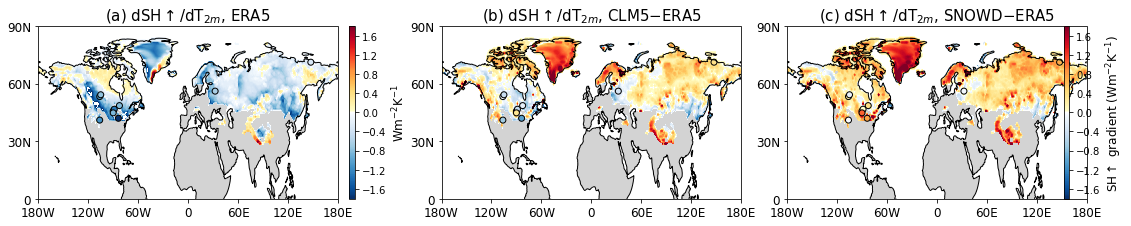

In [30]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, -1.*datera5.bshflx, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(a) d(SH$\\uparrow$)/dT$_{2m}$, ERA5',0.05, 0.31,0.8,0.95)
#ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_era5, datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')
ax = cbars.plotcolorbar(fig, 0.02, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.32,0.325,0.8,0.95,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)



ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datclm5.bshflx - (-1.*datera5.bshflx), datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(b) d(SH$\\uparrow$)/dT$_{2m}$, CLM5$-$ERA5',0.4, 0.66, 0.8, 0.95)
#ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_clm5 - datfluxnet.b_shflx_fnet, 
                                                             datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datsnowd.bshflx - (-1.*datera5.bshflx), datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(c) d(SH$\\uparrow$)/dT$_{2m}$, SNOWD$-$ERA5',0.7, 0.96, 0.8, 0.95)
#ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_snowd - datfluxnet.b_shflx_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = cbars.plotcolorbar(fig, 0.02, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.97,0.975,0.8,0.95,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)



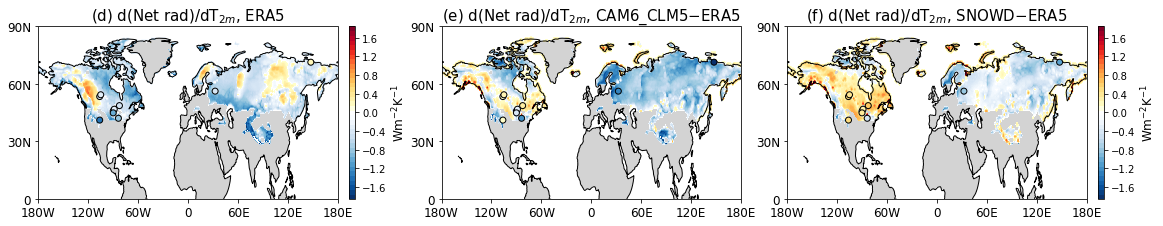

In [32]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(d) d(Net rad)/dT$_{2m}$, ERA5',
                                                0.05, 0.31,0.6,0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_fnet, datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = cbars.plotcolorbar(fig, 0.1, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.32,0.325,0.6,0.75,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)



ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datclm5.bnetrad - datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,
                                            '(e) d(Net rad)/dT$_{2m}$, CAM6_CLM5$-$ERA5',
                                                0.4, 0.66, 0.6, 0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_clm5 - datfluxnet.b_netrad_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')


ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datsnowd.bnetrad - datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,
                                            '(f) d(Net rad)/dT$_{2m}$, SNOWD$-$ERA5',
                                                0.7, 0.96, 0.6, 0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_snowd - datfluxnet.b_netrad_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = cbars.plotcolorbar(fig, 0.1, -1.8, 1.8, 'Wm$^{-2}$K$^{-1}$', 
                        0.97,0.975,0.6,0.75,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)



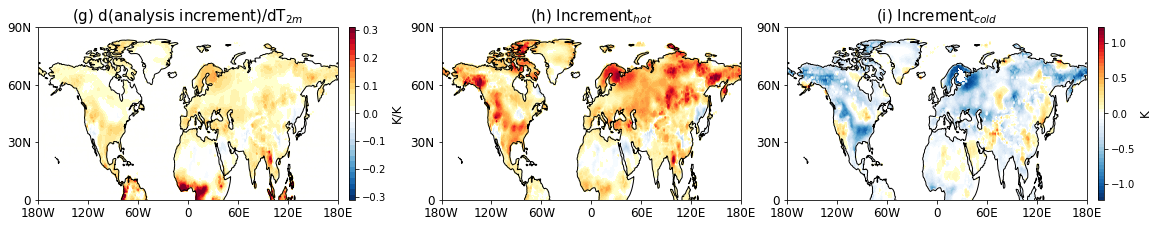

In [25]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5.bincrement, datera5.lon, datera5.lat,
                                               0.02,-0.3,0.3,'(g) d(increment)/dT$_{2m}$',
                                               0.05,0.31,0.4,0.55)
ax = cbars.plotcolorbar(fig, 0.02, -0.3, 0.3, 'K/K', 0.32,0.325,0.4,0.55,
                       ticks=[-0.3,-0.2,-0.1,0,0.1,0.2,0.3], orient='vertical', fsize=10)

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5_comp.maxincrement, datera5_comp.lon, datera5_comp.lat,
                                               0.05,-1.2,1.2,'(h) Increment$_{hot}$ ',0.4,0.66,0.4,0.55)#

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5_comp.minincrement, datera5_comp.lon, datera5_comp.lat,
                                               0.05,-1.2,1.2,'(i) Increment$_{cold}$',0.7,0.96,0.4,0.55)

ax = cbars.plotcolorbar(fig, 0.05, -1.2, 1.2, 'K',0.97,0.975, 0.4,0.55,
                       ticks=[-1,-0.5,0,0.5,1], orient='vertical', fsize=10)

/project/cas/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'level'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


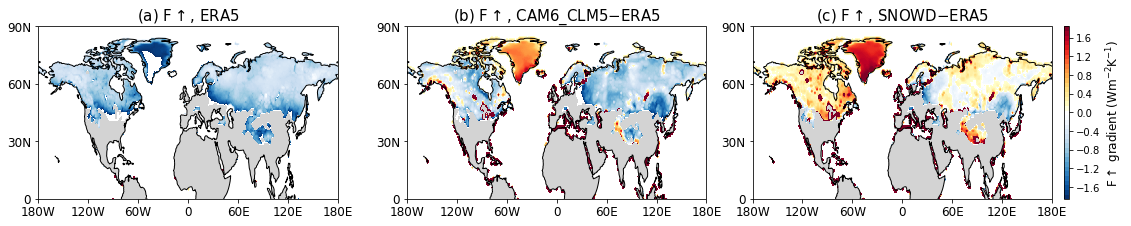

In [8]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5.bsumflux, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(a) F$\\uparrow$, ERA5',0.05, 0.31,0.8,0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datclm5.bsumflux - datera5.bsumflux, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(b) F$\\uparrow$, CAM6_CLM5$-$ERA5',0.37, 0.63, 0.8, 0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')


ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datsnowd.bsumflux - datera5.bsumflux, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(c) F$\\uparrow$, SNOWD$-$ERA5',0.67, 0.93, 0.8, 0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = cbars.plotcolorbar(fig, 0.1, -1.8, 1.8, 'F$\\uparrow$ gradient (Wm$^{-2}$K$^{-1}$)', 0.94,0.945,0.8,0.95,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)



/project/cas/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'level'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


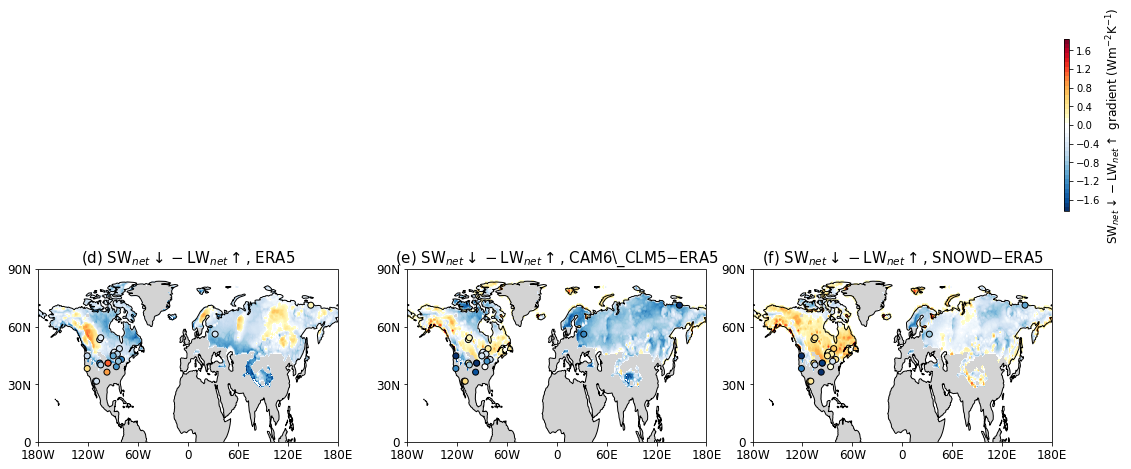

In [15]:
fig = plt.figure(figsize=(16,16))

cmax=1.6 ; cmin=-1.*cmax ; ci =0.02
ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(d) SW$_{net}$$\\downarrow - $LW$_{net}$$\\uparrow$, ERA5',0.05, 0.31,0.6,0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_fnet, datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')




ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datclm5.bnetrad - datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,
                                            '(e) SW$_{net}$$\\downarrow - $LW$_{net}$$\\uparrow$, CAM6\_CLM5$-$ERA5',
                                                0.37, 0.63, 0.6, 0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_clm5 - datfluxnet.b_netrad_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')


ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datsnowd.bnetrad - datera5.bnetrad, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,
                                            '(f) SW$_{net}$$\\downarrow - $LW$_{net}$$\\uparrow$, SNOWD$-$ERA5',0.67, 0.93, 0.6, 0.75)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_netrad_snowd - datfluxnet.b_netrad_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = cbars.plotcolorbar(fig, 0.1, -1.8, 1.8, 'SW$_{net}$$\\downarrow - $LW$_{net}$$\\uparrow$ gradient (Wm$^{-2}$K$^{-1}$)', 0.94,0.945,0.8,0.95,
                       ticks=[-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6], orient='vertical', fsize=10)




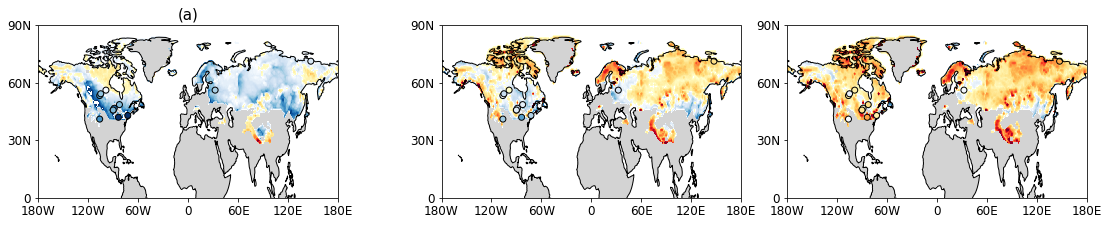

In [67]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, -1.*datera5.bshflx, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(a)',0.05, 0.31,0.8,0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_fnet, datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datclm5.bshflx - (-1.*datera5.bshflx), datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,' ',0.4, 0.66, 0.8, 0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_clm5 - datfluxnet.b_shflx_fnet, 
                                                             datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, datsnowd.bshflx - (-1.*datera5.bshflx), datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,' ',0.7, 0.96, 0.8, 0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_shflx_snowd - datfluxnet.b_shflx_fnet,
                                                            datfluxnet.lon, datfluxnet.lat,
                                                            0.02,-1.8,1.8,edgecolor='black')






/project/cas/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'level'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


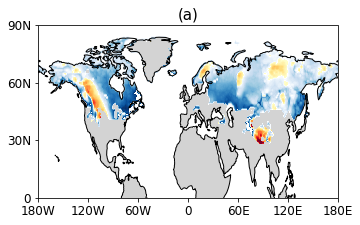

In [36]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_bothcontinents_fill_nh_pos(fig, -1.*datera5.bflns, datera5.lon, datera5.lat,
                                               0.02,-1.8,1.8,'(a)',0.05, 0.31,0.8,0.95)
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskgreenland, level=1, colors='lightgray')
ax.contourf(maskgreenland.lon, maskgreenland.lat, maskclm5inverse, level=1, colors='lightgray')
#ax = maps.contourmap_bothcontinents_fill_nh_pos_oplotscatter(ax, datfluxnet.b_flns_era5, datfluxnet.lon, datfluxnet.lat,
#                                                            0.02,-1.8,1.8,edgecolor='black')